In [17]:
import cv2
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [18]:
MANGA_IMAGES_DIR = r"C:\Workspace\Learning\Projects\Anuvad\python\sampleImages\manga"
MANHUA_IMAGES_DIR = r"C:\Workspace\Learning\Projects\Anuvad\python\sampleImages\manhua"
manga_images = os.listdir(MANGA_IMAGES_DIR)
manga_images_sorted = sorted(manga_images, key=lambda x: int(x.split("-")[0]))
manhua_images = os.listdir(MANHUA_IMAGES_DIR)
manhua_images_sorted = sorted(manhua_images, key=lambda x: int(x.split(".")[0]))
print("Manga Images in Sorted Order:\n", manga_images_sorted, "\n\n")
print("Manhua Images in Sorted Order:\n", manhua_images_sorted, "\n\n")

Manga Images in Sorted Order:
 ['1-66228d3b84417.jpg', '2-66228d3bf2943.jpg', '3-66228d3c5aabf.jpg', '4-66228d3cc2d25.jpg', '5-66228d3d3c3bb.jpg', '6-66228d3e4867b.jpg', '7-66228d3ea607f.jpg', '8-66228d3f18b74.jpg', '9-66228d3f86ce0.jpg', '10-66228d3ff178b.jpg', '11-66228d4068ea1.jpg', '12-66228d40d8238.jpg', '13-66228d413cc26.jpg', '14-66228d41eb36a.jpg', '15-66228d42618f9.jpg', '16-66228d4304b9d.jpg', '17-66228d43e3baf.jpg', '18-66228d446ca28.jpg', '19-66228d45515d9.jpg', '20-66228d4652066.jpg', '21-66228d4775e96.jpg', '22-66228d47f2f86.jpg', '23-66228d48cbb06.jpg', '24-66228d49555f8.jpg', '25-66228d49dcbc0.jpg', '26-66228d4a57dd5.jpg', '27-66228d4ad3bae.jpg', '28-66228d4b56a0b.jpg', '29-66228d4c2fa21.jpg', '30-66228d4d2b01b.jpg'] 


Manhua Images in Sorted Order:
 ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', 

In [19]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return Image.fromarray(binary_img)


def drawImage(image_path, bboxes=[]):
    image = cv2.imread(image_path)
    for bbox in bboxes:
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))
        cv2.rectangle(image, top_left, bottom_right, (0, 0, 255), 2)
    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis("off")  # Turn off axis
    plt.show()


def use_tesseract(image_path):
    img = preprocess_image(image_path)
    with PyTessBaseAPI() as api:  # type:ignore
        api.SetImageFile(img)
        print(api.GetUTF8Text())
        print(api.AllWordConfidences())

In [20]:
img_idx = 1
mode = "manhua"
image_path = (
    os.path.join(MANHUA_IMAGES_DIR, manhua_images_sorted[img_idx])
    if mode == "manhua"
    else os.path.join(MANGA_IMAGES_DIR, manga_images_sorted[img_idx])
)

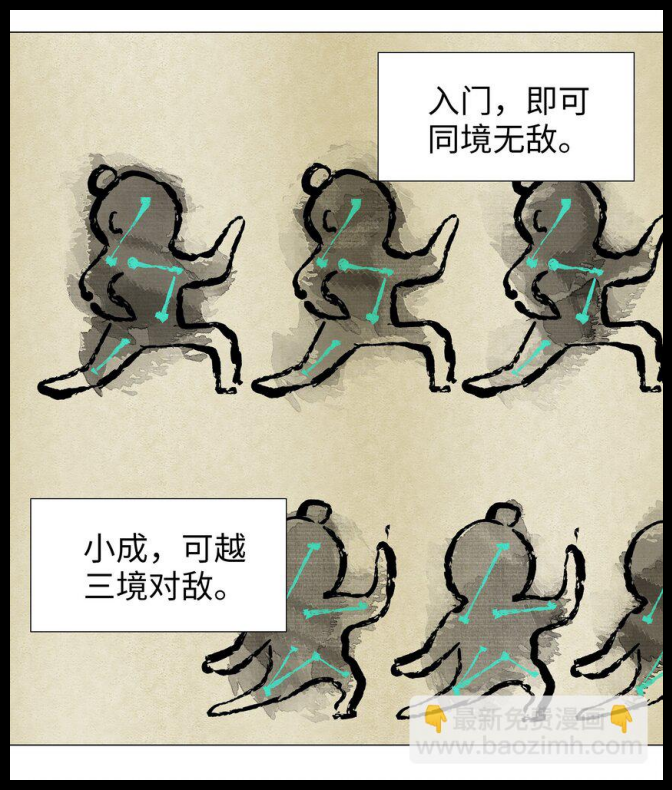

In [21]:
drawImage(image_path)